In [1]:
from params import input_params, time_params
from random_dna_chem import RandomDNAStrandDisplacementCircuit
from perturb_chem import RandomDNAChemPerturbationGillespy2
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import copy


import torch
from torch import nn
from torch.nn import functional
import torch.optim as optim

In [2]:
class ReadOutLayer(nn.Module):
    '''
        Readout layer of Random DNA Strand Displacement Circuit Reservoir Computer
        Single Perceptron that takes concentrations of species inside the reservoir as inputs
        Tasks: Hamming distance learning, Long-term memory task, Short-term memory task
    '''

    def __init__(self, numIn):
        super(ReadOutLayer, self).__init__()
        self.output = nn.Linear(in_features=numIn, out_features=1, bias=True)

    def forward(self, x):
        return self.output(x)

In [3]:
# Train the readout layer
def train_readout(readout, trainset, epochs, device):

    # Define criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(readout.parameters(), lr=0.001)

    # Initialize a list of losses and a running loss
    losses = []
    running_loss = 0

    x_matrix = [] # matrix of all concentration vectors
    for concentration in trainset.values():
        x_matrix.append(concentration)

    # Go through each epoch
    for epoch in range(epochs):
        losses_per_epoch = []
        # Go through each timestep
        for i in range(len(trainset['U0'])):
            # Build the input and target
            target = [trainset['U0'][i]] # target vector is concentration of U0 species
            x_matrix_i = [] # vector of the ith element of each species concentration in matrix
            for species_index in range(len(trainset)):
                x_matrix_i.append(x_matrix[species_index][i]) 
            x = torch.Tensor(x_matrix_i)
            y = torch.Tensor(target)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Make a forward pass, calculate loss, and backpropogate
            output = readout(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            # Stats
            losses_per_epoch.append(loss.item())
            running_loss += loss.item()
            if i % 1000 == 0: # calculate cumulative loss over 1000 timestep
                print("\tepoch {}, inst {:<4}\trunning loss: {}".format(epoch, i, running_loss))
                running_loss = 0
        losses.append(losses_per_epoch)
    # Return list of losses, containing list of losses per epoch
    return losses


In [4]:
# Test the readout layer
def test_readout(readout, testset, device):

    # Initialize tracking variables
    total = 0
    correct = 0

    x_matrix = [] # matrix of all concentration vectors
    for concentration in testset.values():
        x_matrix.append(concentration)

    # Go through each timestep
    for i in range(len(testset['U0'])):
        # Build the input and target
        target = [testset['U0'][i]] # target vector is concentration of U0 species
        x_matrix_i = [] # vector of the ith element of each species concentration in matrix
        for species_index in range(len(testset)):
            x_matrix_i.append(x_matrix[species_index][i]) 
        x = torch.Tensor(x_matrix_i)
        y = torch.Tensor(target)

        # Make a forward pass, check for accuracy
        output = readout(x)
        total += 1
        if abs(output.item() - y.item()) < 0.01:
            correct += 1

        # Stats
        if i % 1000 == 0: # calculate cumulative accuracy over the entire simulation time up to each 1000 timestep
            print("\tinst {:<4}\tcurrent accuracy: {:.3f}%".format(i, (correct / total) * 100))

    # Print final result
    print("\tFinal accuracy: {:.3f}%".format((correct / total) * 100))



Generating data...


2020-03-27 23:13:46,752 - root - WARNING -  Unable to use Cython optimized SSA: Building module gillespy2.solvers.cython.cython_ssa_solver failed: ['distutils.errors.DistutilsPlatformError: Unable to find vcvarsall.bat\n']. The performance of this package can be significantly increased if you install Cython.


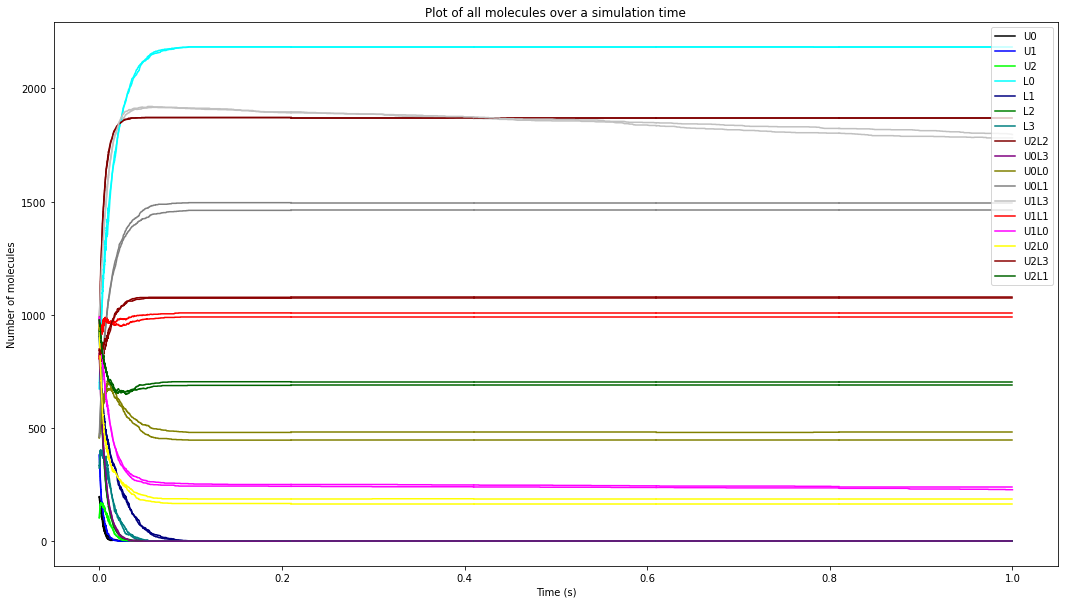

In [5]:
# Load data
print("\nGenerating data...")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

randomDNAChem = RandomDNAStrandDisplacementCircuit(input_params=input_params, 
                                                   time_params=time_params)
numIn = randomDNAChem.species_lookup['nS']

color_array = ['#000000', '#0000FF', '#00FF00', '#00FFFF', '#000080',
               '#008000', '#008080', '#800000', '#800080', '#808000',
               '#808080', '#C0C0C0', '#FF0000', '#FF00FF', '#FFFF00',
               '#8B0000', '#006400', '#BDB76B', '#008B8B', '#191970']

plt.figure(figsize = (18,10))
plt.title('Plot of all molecules over a simulation time')
plt.xlabel('Time (s)')
plt.ylabel('Number of molecules')

gillespy2_results = []
num_trajectories = 2
num_time_element = 1001

# Creating the Gillespy2 chemistry model in the non-perturb period
gillespy2_model = RandomDNAChemPerturbationGillespy2(non_gillespy2_chem=randomDNAChem,
                                                     rate_in_timeIndex=0, # index 0 for time t=0
                                                     period_start=randomDNAChem.time_params['time_array'][0],
                                                     period_end=randomDNAChem.time_params['time_array'][1],
                                                     numel=num_time_element,
                                                     previous_gillespy2_result=None)

# Result of stochastic Gillespie simulation for non-perturbation period
gillespy2_result = gillespy2_model.run(number_of_trajectories=num_trajectories)

# Result of stochastic Gillespie simulation for entire simulation time
gillespy2_results.append(gillespy2_result)

# Plot non-perturb period
for index in range(num_trajectories):
    trajectory = gillespy2_result[index]
    for species_index, species in enumerate(randomDNAChem.species_lookup['S']):
        species_plot = plt.plot(trajectory['time'],
                                trajectory['{}'.format(species)],
                                color=color_array[species_index],
                                label=species)

# Creating the Gillespy2 chemistry models in the perturb period
for time_index in range(1, len(randomDNAChem.time_params['time_array']) - 1):
    # Calculate the Gillespy2 time offset
    time_offset = randomDNAChem.time_params['t_perturb'] + randomDNAChem.time_params['t_hold'] * (time_index - 1)

    trajectories = []
    for index in range(num_trajectories):
        previous_trajectory = gillespy2_result[index] # take the gillespy2_result from the previous period

        # Creating one Gillespy2 chemistry model in one trajectory in one perturb period
        gillespy2_model = RandomDNAChemPerturbationGillespy2(non_gillespy2_chem=randomDNAChem,
                                                             rate_in_timeIndex=time_index, # index 1 for time t=1 and so on
                                                             period_start=randomDNAChem.time_params['time_array'][time_index] - time_offset,
                                                             period_end=randomDNAChem.time_params['time_array'][time_index + 1] - time_offset,
                                                             numel=num_time_element,
                                                             previous_gillespy2_result=previous_trajectory)
        trajectory = gillespy2_model.run(number_of_trajectories=1) # run the single trajectory
        trajectories.append(trajectory)
    gillespy2_result = trajectories # gillespy2_result of the current period

    # Result of stochastic Gillespie simulation for entire simulation time
    gillespy2_results.append(gillespy2_result)

    # Plot each of the perturb period
    for index in range(num_trajectories):
        trajectory = gillespy2_result[index]
        for species_index, species in enumerate(randomDNAChem.species_lookup['S']):
            species_plot = plt.plot(trajectory['time'] + time_offset,
                                    trajectory['{}'.format(species)],
                                    color=color_array[species_index],
                                    label=species)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
# plot_name = 'random_dna_chem_with_perturb_junk'
try:
    plot_name
except NameError:
    plt.show()
else:
    plt.savefig('plots/' + plot_name + '.eps')


Training model: 
	epoch 0, inst 0   	running loss: 0.9922221302986145
	epoch 0, inst 1000	running loss: 19.569094906933824
	epoch 0, inst 2000	running loss: 0.05034355747884578
	epoch 0, inst 3000	running loss: 7.031281814118273e-06
	epoch 0, inst 4000	running loss: 1.0031096818519103e-05
	epoch 0, inst 5000	running loss: 0.00015189547480876087
	epoch 0, inst 6000	running loss: 3.1661501554980376e-05
	epoch 1, inst 0   	running loss: 0.053713757544755936
	epoch 1, inst 1000	running loss: 1.360942106464495
	epoch 1, inst 2000	running loss: 0.04872672532365763
	epoch 1, inst 3000	running loss: 7.038697498185087e-06
	epoch 1, inst 4000	running loss: 1.0041017212136794e-05
	epoch 1, inst 5000	running loss: 0.0001477768395785617
	epoch 1, inst 6000	running loss: 3.2087025702676186e-05
	epoch 2, inst 0   	running loss: 0.03770557418465614
	epoch 2, inst 1000	running loss: 1.0473671606249242
	epoch 2, inst 2000	running loss: 0.04729310621649474
	epoch 2, inst 3000	running loss: 7.041004804753

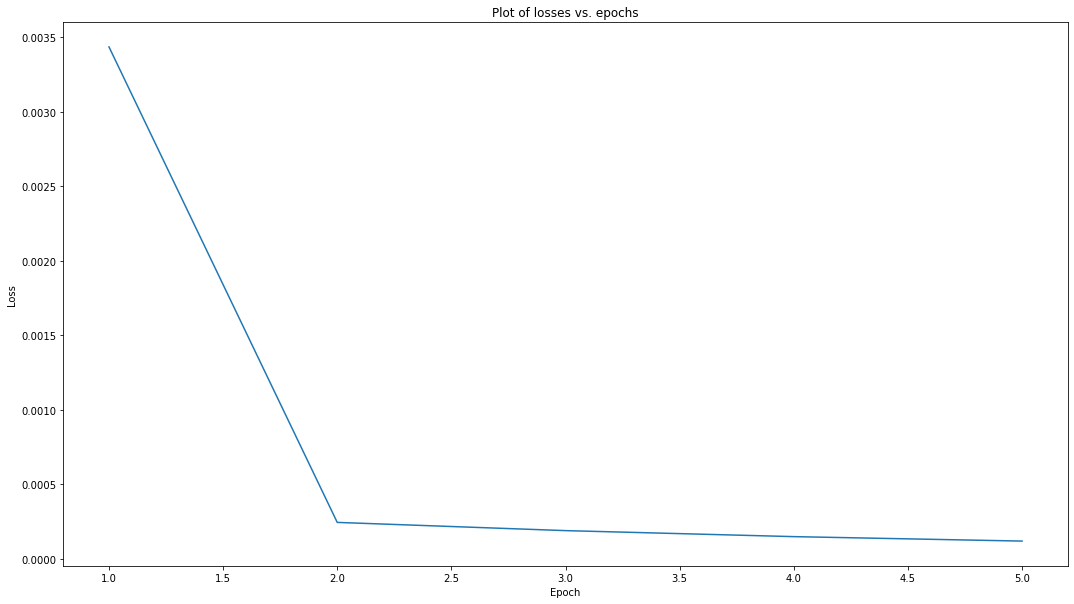

In [6]:
# Create trainset: Concentration from reservoir = readout inputs (use trajectory 0 for trainset)
trajectory_in_use = 0
time_lookup0 = list(gillespy2_results[0][trajectory_in_use]['time']) # time vector at non-perturbed period
for time_index in range(1, randomDNAChem.time_params['num_perturb'] + 1): # time vector at perturbed period
    time_offset = randomDNAChem.time_params['t_perturb'] + randomDNAChem.time_params['t_hold'] * (time_index - 1)
    time_per_period = np.delete(gillespy2_results[time_index][trajectory_in_use]['time'], 0) # delete the 0th element since repeat
    time_lookup0 += list(time_per_period + time_offset)

concentration_lookup0 = {}
for species_name in randomDNAChem.species_lookup['S']:
    concentrations = list(gillespy2_results[0][trajectory_in_use][species_name]) # concentration vector at non-perturbed period
    for time_index in range(1, randomDNAChem.time_params['num_perturb'] + 1): # concentration vector at perturbed period
        concentration_per_period = np.delete(gillespy2_results[time_index][trajectory_in_use][species_name], 0) # delete the 0th element since repeat
        concentrations += list(concentration_per_period)
    concentration_lookup0.update({'{}'.format(species_name): concentrations})

trainset = copy.deepcopy(concentration_lookup0) # trainset is a scaled concentration lookup
for species_name, concentration in trainset.items():
    scale_factor = max(concentration) / 1 # scale the concentration value between 0 and 1
    for i in range(len(concentration)):
        trainset[species_name][i] = concentration[i] / scale_factor

# Training
print('Training model: ')
readout = ReadOutLayer(numIn=numIn)
num_epoch = 5
losses = train_readout(readout=readout, trainset=trainset, epochs=num_epoch, device=device)
avg_losses_per_epoch = []
for i in range(num_epoch): # list index 0 (epoch 1) to list index 4 (epoch 5)
    avg_losses_per_epoch.append(np.mean(losses[i]))

plt.figure(figsize = (18,10))
plt.title('Plot of losses vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epoch+1), avg_losses_per_epoch)
# plt.savefig('losses_vs_epochs' + '.eps')
plt.show()


In [7]:
# Create testset: Concentration from reservoir = readout inputs (use trajectory 1 for testset)
trajectory_in_use = 1
time_lookup1 = list(gillespy2_results[0][trajectory_in_use]['time']) # time vector at non-perturbed period
for time_index in range(1, randomDNAChem.time_params['num_perturb'] + 1): # time vector at perturbed period
    time_offset = randomDNAChem.time_params['t_perturb'] + randomDNAChem.time_params['t_hold'] * (time_index - 1)
    time_per_period = np.delete(gillespy2_results[time_index][trajectory_in_use]['time'], 0) # delete the 0th element since repeat
    time_lookup1 += list(time_per_period + time_offset)

concentration_lookup1 = {}
for species_name in randomDNAChem.species_lookup['S']:
    concentrations = list(gillespy2_results[0][trajectory_in_use][species_name]) # concentration vector at non-perturbed period
    for time_index in range(1, randomDNAChem.time_params['num_perturb'] + 1): # concentration vector at perturbed period
        concentration_per_period = np.delete(gillespy2_results[time_index][trajectory_in_use][species_name], 0) # delete the 0th element since repeat
        concentrations += list(concentration_per_period)
    concentration_lookup1.update({'{}'.format(species_name): concentrations})

testset = copy.deepcopy(concentration_lookup1) # testset is a scaled concentration lookup
for species_name, concentration in testset.items():
    scale_factor = max(concentration) / 1 # scale the concentration value between 0 and 1
    for i in range(len(concentration)):
        testset[species_name][i] = concentration[i] / scale_factor

# Testing
print('Testing model: ')
test_readout(readout=readout, testset=testset, device=device)



Testing model: 
	inst 0   	current accuracy: 0.000%
	inst 1000	current accuracy: 18.681%
	inst 2000	current accuracy: 9.345%
	inst 3000	current accuracy: 6.231%
	inst 4000	current accuracy: 4.674%
	inst 5000	current accuracy: 8.578%
	inst 6000	current accuracy: 23.813%
	Final accuracy: 23.813%


In [8]:
print(len(time_lookup1))

6001


In [9]:
print(time_lookup1)

[0.0, 1e-05, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0001, 0.00011, 0.00012000000000000002, 0.00013000000000000002, 0.00014000000000000001, 0.00015000000000000001, 0.00016, 0.00017, 0.00018, 0.00019, 0.0002, 0.00021, 0.00022, 0.00023, 0.00024000000000000003, 0.00025, 0.00026000000000000003, 0.00027, 0.00028000000000000003, 0.00029, 0.00030000000000000003, 0.00031, 0.00032, 0.00033000000000000005, 0.00034, 0.00035000000000000005, 0.00036, 0.00037000000000000005, 0.00038, 0.00039000000000000005, 0.0004, 0.00041000000000000005, 0.00042, 0.00043000000000000004, 0.00044, 0.00045000000000000004, 0.00046, 0.00047000000000000004, 0.00048000000000000007, 0.0004900000000000001, 0.0005, 0.00051, 0.0005200000000000001, 0.0005300000000000001, 0.00054, 0.00055, 0.0005600000000000001, 0.0005700000000000001, 0.00058, 0.00059, 0.0006000000000000001, 0.0006100000000000001, 0.00062, 0.00063, 0.00064, 0.0006500000000000001, 0.0006600000000

0.0
0.0102
0.21040000000000003
0.4106
0.6108000000000001
0.8109500000000001
460.0
1073.0
1495.0
1495.0
1495.0
1495.0
17
6001
0.00119148731599689
0.0016433543620363413
0.0022452326144703836
0.0014142810752414872
0.0015033795485802663
0.000801680049987246


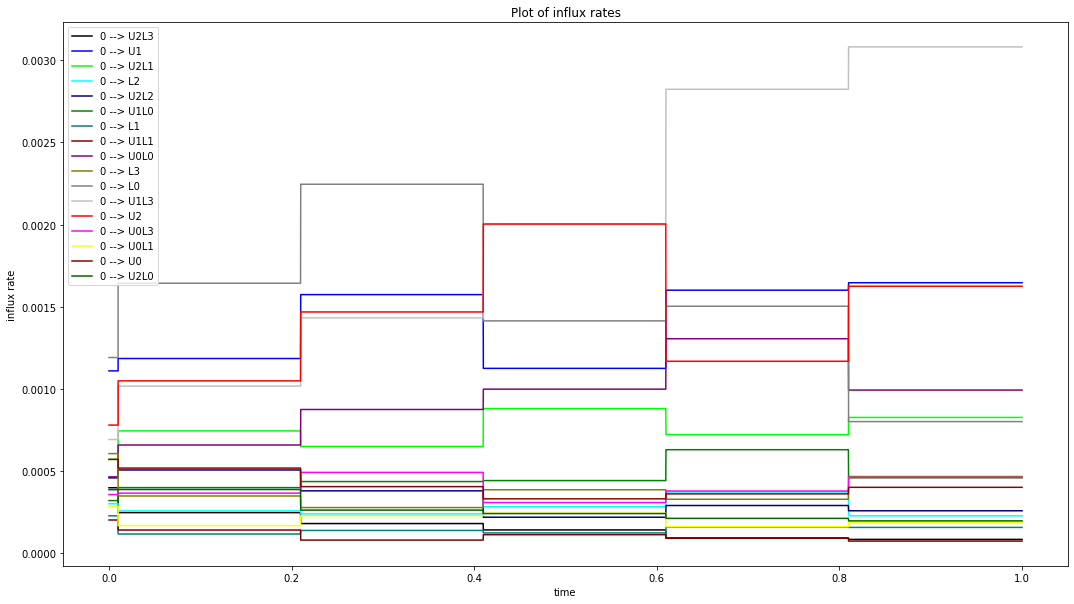

In [11]:
# from more_itertools import locate

# zero = list(locate(time_lookup1, lambda inst: inst == 0.0))
# print(zero)
# one = list(locate(time_lookup1, lambda inst: inst == 0.01))
# print(one)
# two = list(locate(time_lookup1, lambda inst: inst == 0.21))
# print(two)
# three = list(locate(time_lookup1, lambda inst: inst == 0.41))
# print(three)
# four = list(locate(time_lookup1, lambda inst: inst == 0.61))
# print(four)
# five = list(locate(time_lookup1, lambda inst: inst == 0.81))
# print(five)
# six = list(locate(time_lookup1, lambda inst: inst == 1))
# print(six)

num_period = 6

# print(time_lookup[0])
# print(time_lookup[999:1000 + 1])
# print(time_lookup[1999:2000 + 1])
# print(time_lookup[2999:3000 + 1])
for i in range(0, randomDNAChem.time_params['num_perturb'] + 1):
    print(time_lookup1[i * num_time_element])

for i in range(0, randomDNAChem.time_params['num_perturb'] + 1):
    print(concentration_lookup1['U0L1'][i * num_time_element])

print(len(randomDNAChem.rateConst_lookup['rate_IN']))

# Make influx rate array the same length as time array
influx_lookup = randomDNAChem.rateConst_lookup['rate_IN'].copy()
for r_in, rate_in in randomDNAChem.rateConst_lookup['rate_IN'].items():
    influx_rate_per_reaction = []
    for ir in rate_in:
        influx_rate_per_reaction += [ir] * (num_time_element-1)
    influx_rate_per_reaction.append(influx_rate_per_reaction[-1])
    influx_lookup.update({'{}'.format(r_in): influx_rate_per_reaction})

print(len(influx_lookup['0 --> L0']))

for i in range(0, randomDNAChem.time_params['num_perturb'] + 1):
    print(influx_lookup['0 --> L0'][i * num_time_element])
    
# print('Influx reactions and rates:')
# for r_in, rate_in in randomDNAChem.rateConst_lookup['rate_IN'].items():
#     print('{}    {}'.format(r_in, rate_in))
# print('\n')

# print(randomDNAChem.rateConst_lookup['rate_IN'])
# print(influx_lookup)

plt.figure(figsize = (18,10))
plt.title('Plot of influx rates')
plt.xlabel('time')
plt.ylabel('influx rate')
for reaction_index, (reaction, influx_rate) in enumerate(influx_lookup.items()):
    plt.plot(time_lookup1, influx_rate, color=color_array[reaction_index], label=reaction)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()


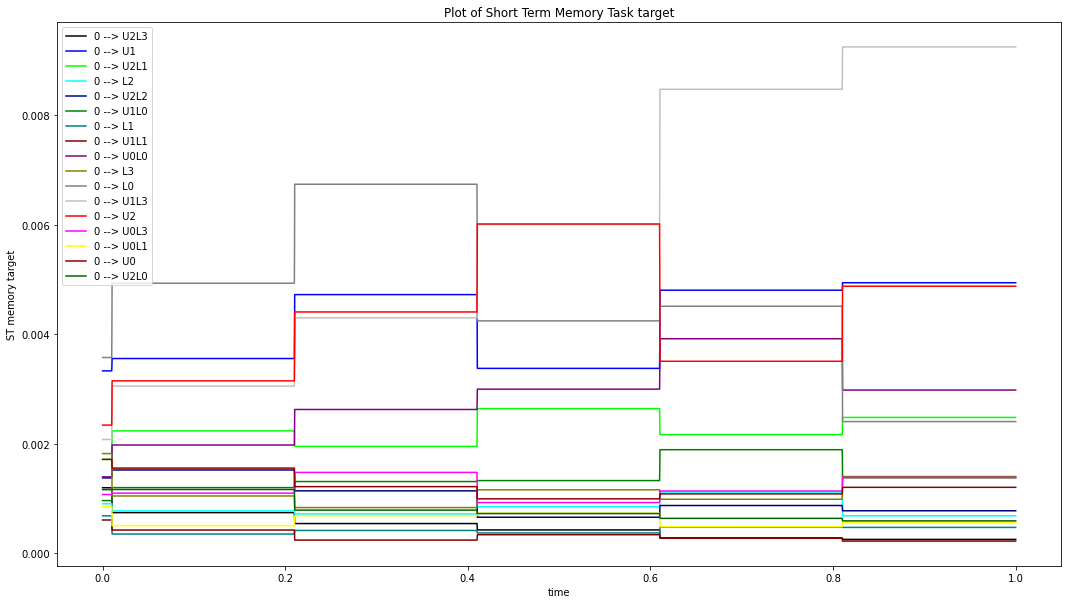

In [30]:
ST_lookup = influx_lookup.copy() # lookup dict for short term memory task target for all reactions
for r_in, rate_in in ST_lookup.items():
    ST_target_per_reaction = []
    for ir_index in range(2, len(time_lookup1) + 1): # from index 2 to index end+1
        ST_target_per_reaction.append(rate_in[ir_index - 1] + 2*rate_in[ir_index - 2])
    ST_lookup.update({'{}'.format(r_in): ST_target_per_reaction})

plt.figure(figsize = (18,10))
plt.title('Plot of Short Term Memory Task target')
plt.xlabel('time')
plt.ylabel('ST memory target')
for reaction_index, (reaction, ST_target) in enumerate(ST_lookup.items()):
    plt.plot(time_lookup1[2:], ST_target[:-1], color=color_array[reaction_index], label=reaction)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()


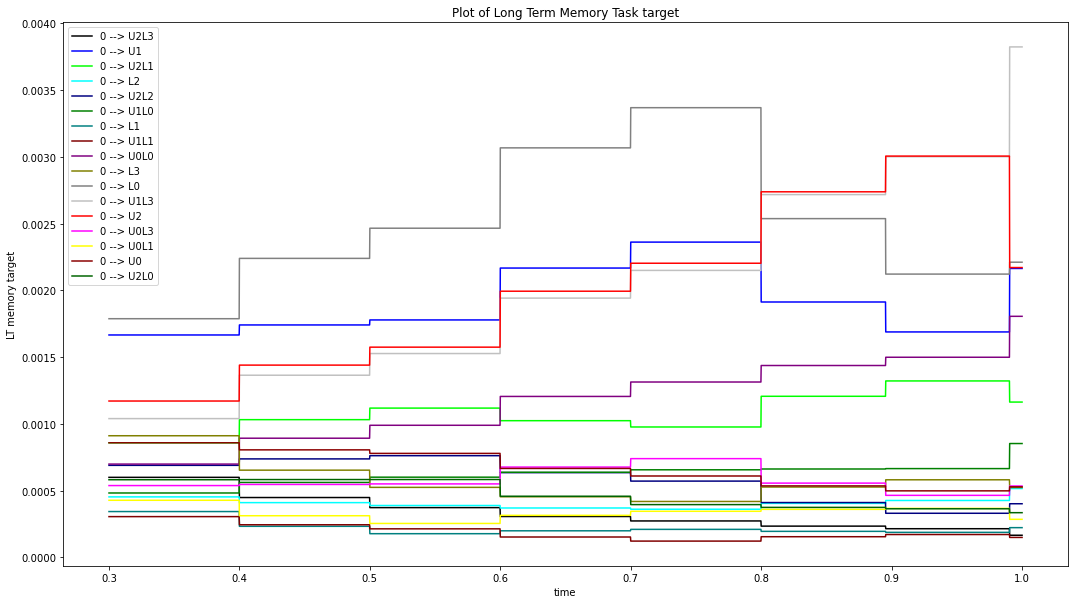

In [33]:
t_hold = randomDNAChem.time_params['t_hold']
t_hold_index = time_lookup1.index(t_hold)
t_hold_32_index = time_lookup1.index(t_hold*(3/2))
LT_lookup = influx_lookup.copy() # lookup dict for short term memory task target for all reactions
for r_in, rate_in in LT_lookup.items():
    LT_target_per_reaction = []
    for ir_index in range(t_hold_32_index, len(time_lookup1) + t_hold_index): # from index hold_time to index end + index (3/4)*hold_time
        LT_target_per_reaction.append(rate_in[ir_index - t_hold_index] + (1/2)*rate_in[ir_index - t_hold_32_index])
    LT_lookup.update({'{}'.format(r_in): LT_target_per_reaction})

plt.figure(figsize = (18,10))
plt.title('Plot of Long Term Memory Task target')
plt.xlabel('time')
plt.ylabel('LT memory target')
for reaction_index, (reaction, LT_target) in enumerate(LT_lookup.items()):
    plt.plot(time_lookup1[t_hold_32_index:], LT_target[:-t_hold_index], color=color_array[reaction_index], label=reaction)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()


In [ ]:
print([len(concentration_lookup0), len(concentration_lookup1)]) # length is number of species

In [ ]:
print([len(concentration_lookup0['U0']), len(concentration_lookup1['U0'])]) # length is same as length of time array

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Concentration of all species')
plt.xlabel('time')
plt.ylabel('concentration')
for species_index, (species, concentration) in enumerate(concentration_lookup0.items()):
    plt.plot(time_lookup0, concentration, color=color_array[species_index], label=species)
for species_index, (species, concentration) in enumerate(concentration_lookup1.items()):
    plt.plot(time_lookup1, concentration, color=color_array[species_index], label=species)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()
